<a href="https://colab.research.google.com/github/nitrus96/Deep-RL/blob/master/A2C/Advantage_A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Average score over 10 episodes at episode 10 : 22.0
Average score over 10 episodes at episode 20 : 15.6
Average score over 10 episodes at episode 30 : 15.4
Average score over 10 episodes at episode 40 : 10.9
Average score over 10 episodes at episode 50 : 11.7
Average score over 10 episodes at episode 60 : 12.0
Average score over 10 episodes at episode 70 : 16.2
Average score over 10 episodes at episode 80 : 14.3
Average score over 10 episodes at episode 90 : 14.5
Average score over 10 episodes at episode 100 : 14.2
Average score over 10 episodes at episode 110 : 12.1
Average score over 10 episodes at episode 120 : 12.7
Average score over 10 episodes at episode 130 : 15.8
Average score over 10 episodes at episode 140 : 19.4
Average score over 10 episodes at episode 150 : 12.9
Average score over 10 episodes at episode 160 : 14.2
Average score over 10 episodes at episode 170 : 18.1
Average score over 10 episodes at episode 180 : 15.3
Average score over 10 episodes at episode 190 : 18.0
Av

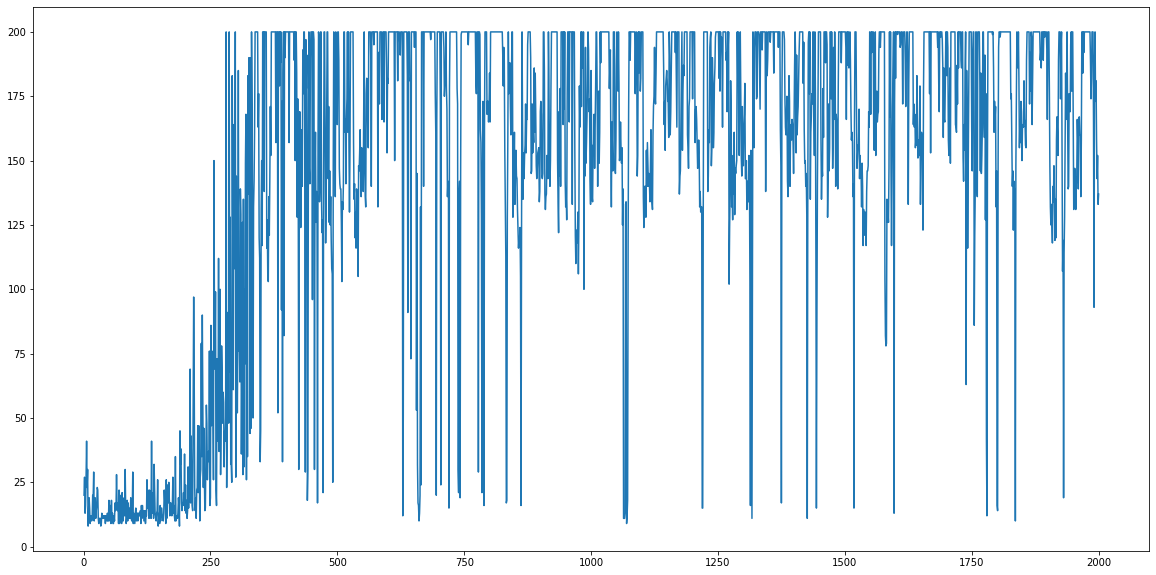

In [0]:
import random
from itertools import count
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras import models, layers
from tensorflow.keras.initializers import glorot_normal
from collections import deque
from tensorflow.keras.optimizers import Adam

### Environment ##
ENV = gym.make('CartPole-v0')
OBSERVATION_SPACE = ENV.observation_space.shape[0]
ACTION_SPACE = ENV.action_space.n

### Hyperparameters ###
LR_ACTOR = 0.00001
LR_CRITIC = 0.00007
GAMMA = 0.975

EPISODES = 2000

class Agent():
    
    def __init__(self):
        # Initalize actor and critic networks
        self.actor, self.critic, self.sampler = self.DQNet()
    
    def DQNet(self):
        # Actor and critic networks are to share weights and layers
        observation = layers.Input(shape=(OBSERVATION_SPACE,))
        advantage = layers.Input(shape=[1])
        layer_1 = layers.Dense(1024, activation='relu')(observation)
        layer_2 = layers.Dense(512, activation='relu')(layer_1)
        layer_3 = layers.Dense(128, activation='relu')(layer_2)
        # Output for actor network
        probs = layers.Dense(ACTION_SPACE, activation='softmax')(layer_3)
        # Output for critic network
        value = layers.Dense(1, activation='linear')(layer_3)

        # Define custom loss function
        def AAC_loss(y_true, y_pred):
            # Clip probability values as to not take log of 0 or 1
            y_pred = K.clip(y_pred, 0.0000001, 1-0.0000001)
            # y_true is a one-hot vector
            take_log = y_true*K.log(y_pred)
            return K.sum(-take_log*advantage)

        actor = models.Model(inputs=[observation, advantage], outputs=[probs])
        critic = models.Model(inputs=[observation], outputs=[value])
        sampler = models.Model(inputs=[observation], outputs=[probs])

        actor.compile(optimizer=Adam(lr=LR_ACTOR), loss=AAC_loss)
        critic.compile(optimizer=Adam(lr=LR_CRITIC), loss='mse')
        
        return actor, critic, sampler

    def sample_action(self, state):
        # Get probability distribution of actions and sample an action
        prob_dist = self.sampler.predict(state)[0]
        action = np.random.choice(ACTION_SPACE, p=prob_dist)
        return action

    def advantage_function(self, state, next_state, reward, done):
        v_s = self.critic.predict(state)
        v_next_s = self.critic.predict(next_state)
        target = reward + GAMMA*v_next_s*(1-int(done))
        advantage = target - v_s
        return target, advantage

    def update(self, state, next_state, reward, action, advantage, target):
        # Represent action taken as a one-hot vector
        actions = np.zeros([1, ACTION_SPACE])
        actions[0][action] = 1
        # Perform update
        self.actor.fit([state, advantage], actions, verbose=0)
        self.critic.fit(state, target, verbose=0)


class Env():
    
    def __init__(self, env, mode='train'):
        self.env = env
        self.agent = Agent()
        self.episode = 0
        self.scores = 0
        self.chart_performance = []
        self.train()

    def train(self):
        # Start playing
        for episode in range(EPISODES):
            self.play_episode()
        # Plot scores for each episode when done training
        plt.figure(figsize=(20,10))
        plt.plot(np.arange(1, EPISODES+1), self.chart_performance)
        plt.show()

    def play_episode(self):
        s = self.env.reset().reshape(1,OBSERVATION_SPACE)
        counter = 0
        while True:
            a = self.agent.sample_action(s)
            # Sample the reward and next state
            next_s, r, done, info = self.env.step(a)
            next_s = next_s.reshape(1,OBSERVATION_SPACE)
            counter += 1
            # Get target and advantage terms
            target, adv = self.agent.advantage_function(s, next_s, r, done)
            # Update actor and critic params
            self.agent.update(s, next_s, r, a, adv, target)
            # Update statistics at the end of each episode
            if done:
                self.episode += 1
                self.scores += counter
                self.chart_performance.append(counter)
                if self.episode % 10 == 0:
                    print("Average score over 10 episodes at episode {} : {}".format(self.episode, self.scores/10))
                    self.scores = 0
                break
            s = next_s